Step: 
================================ Human Message =================================

Use get_pose_data with video_path="/Users/hastiabbasi/agentic-updrs/agentic-updrs/FT_vids/sub1vid7.mp4"


/Users/hastiabbasi/agentic-updrs/agentic-updrs/.venv/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


tool_calls: []
Gemini message content:  Please provide the path to the video file you would like me to analyze.
Step: 
================================== Ai Message ==================================

Please provide the path to the video file you would like me to analyze.


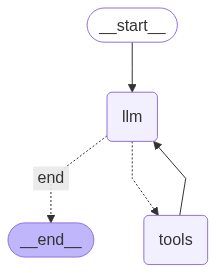

In [ ]:
import os 
from dotenv import load_dotenv
from typing import TypedDict, Optional, Dict, Any
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langchain_google_genai import ChatGoogleGenerativeAI
from utils.pose_utils import extract_keypoints
import numpy as np

from langchain_core.messages import ToolMessage, HumanMessage, BaseMessage
from langgraph.graph.message import add_messages
from typing import Annotated, Sequence
from langchain_core.runnables import RunnableConfig

# import for visual representation of graph
from IPython.display import Image, display

# import for video input
from pydantic import BaseModel, Field

# load env variables
load_dotenv()
assert os.getenv("GOOGLE_API_KEY"), "GOOGLE_API_KEY not set in environment."

# define state
class GraphState(TypedDict):
    user_input: str
    video_path: str
    pose_data: Optional[Any]
    velocity_data: Optional[Dict[str, float]]
    score_output: Optional[dict[str, Any]]

class PoseInput(BaseModel):
    video_path: str = Field(description="The full local path to the video to analyze for UPDRS scoring.")

@tool("get_pose_data", args_schema=PoseInput)
def get_pose_data_tool(input: PoseInput) -> Dict:
    """Extracts RIGHT_INDEX and RIGHT_THUMB keypoints from a video using MediaPipe."""
    pose = extract_keypoints(input.video_path, joints=["RIGHT_INDEX", "RIGHT_THUMB"])
    print(f"get_pose_data: extracted {len(pose)} frames")
    return {"pose_data": pose}

@tool 
def analyze_finger_velocity(pose_data: Any) -> Dict[str, float]:
    """Computes average tapping velocity from pose keypoints."""
    velocities = []
    for i in range(1, len(pose_data)):
        prev = pose_data[i - 1]
        curr = pose_data[i]

        if "RIGHT_INDEX" in prev and "RIGHT_INDEX" in curr:
            dx = curr["RIGHT_INDDEX"][0] - prev["RIGHT_INDEX"][0]
            dy = curr["RIGHT_INDEX"][1] - prev["RIGHT_INDEX"][1]
            velocities.append(np.sqrt(dx ** 2 + dy ** 2) * 30)
        
    avg_velocity = float(np.mean(velocities)) if velocities else 0.0
    print(f"analyze_finger_velocity: avg_velocity = {avg_velocity:.4f}")
    return {"avg_velocity": avg_velocity}

@tool
def score_updrs(avg_velocity: float) -> Dict[str, Any]:
    """Scores UPDRS Finger Tapping task based on average velocity."""
    if avg_velocity > 1.5:
        score = 0
        rationale = "Normal tapping speed"
    elif avg_velocity > 1.0:
        score = 1
        rationale = "Slight slowing"
    elif avg_velocity > 0.5:
        score = 2
        rationale = "Moderate slowing"
    else:
        score = 3
        rationale = "Sever bradykinesia"

    print(f"score_updrs: score = {score}, rationale = {rationale}")
    return {"score": score, "rationale": rationale, "velocity": avg_velocity}

# tool bindings for LangGraph
tools = [get_pose_data_tool, analyze_finger_velocity, score_updrs]
tools_by_name = {t.name: t for t in tools}

# initialize gemini 
llm = ChatGoogleGenerativeAI(
    model = "gemini-2.5-pro",
    temperature = 0.2,
    convert_system_message_to_human=True,
    streaming=False
)

model = llm.bind_tools(tools)

# LangGraph nodes
def call_model(state: GraphState, config: RunnableConfig) -> Dict:
    # use existing message chain
    response = model.invoke(["messages"], config)
    print("tool_calls:", getattr(response, "tool_calls", None))
    print("Gemini message content: ", response.content)
    return {"messages": [response]}

def call_tool(state: GraphState) -> Dict:
    messages = state.get("messages", [])
    last_msg = messages[-1]
    tool_outputs = []

    for call in last_msg.tool_calls:
        tool = tools_by_name[call["name"]]
        result = tool.invoke(call["args"])
        tool_outputs.append(ToolMessage(content=result, name=call["name"], tool_call_id=call["id"]))
    
    return {"messages": tool_outputs}

def should_continue(state: GraphState) -> str:
    messages = state.get("messages", [])

    if messages and hasattr(messages[-1], "tool_calls") and messages[-1].tool_calls:
        return "tools"
    return "end"

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

workflow = StateGraph(AgentState)
workflow.add_node("llm", call_model)
workflow.add_node("tools", call_tool)
workflow.set_entry_point("llm")
workflow.add_conditional_edges("llm", should_continue, {
    "tools": "tools",
    "end": END,
})
workflow.add_edge("tools", "llm")

graph = workflow.compile()

if __name__ == "__main__":
    
    # visual representation of graph
    display(Image(graph.get_graph().draw_mermaid_png()))